In [15]:
# import necessary modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import torch
import configparser
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
# plt.style.use('sketch')
# plt.style.use('publication')
plt.rcParams['text.usetex'] = True
from os.path import join as oj


sys.path.append('../src')
from data_loading import H5pyDataset
from unet_model import UNet

import data_utils
# set up device
cuda = torch.cuda.is_available()
torch.set_num_threads(1)
device = torch.device("cuda" if cuda else "cpu")

# set up config parser
config = configparser.ConfigParser()
config.read('../config.ini')

# set up model path
model_path = config["PATHS"]["model_unet_path"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [16]:
best_idx = 0
config.read("../config.ini")
data_folder = config["DATASET"]["dataPath"]

all_dataset = H5pyDataset( oj(data_folder, "phase_field.h5"), offset=2, start_offset=1, scale=1, num_channels=1, percentage = 1, )
all_dataset2 = H5pyDataset( oj(data_folder, "phase_field_test.h5"), offset=2, start_offset=1, scale=1, num_channels=1, percentage = 1, )
all_dataset3 = H5pyDataset( oj(data_folder, "phase_field_val.h5"), offset=2, start_offset=1, scale=1, num_channels=1, percentage = 1, )
all_dataset4 = H5pyDataset( oj(data_folder, "phase_field_ood.h5"), offset=2, start_offset=1, scale=1, num_channels=1, percentage = 1, )

In [6]:
len(all_dataset.key_list)

990

In [110]:
arr_of_numbers = []
for name in all_dataset.key_list:

    arr_of_numbers.append(int((name.split('_')[-2][:-3])))
arr_of_numbers = np.array(arr_of_numbers)

In [159]:
arr_of_numbers

array([140,  80, 140, 140, 200, 140,  40, 180, 200,  30,  60, 180,  60,
       120, 140, 120, 180,  30, 120, 180,  80, 200, 120,  80,  60,  60,
        40,  30,  30,  40, 100,  60,  30,  80,  80, 200, 100, 200, 100,
       200, 200, 140, 180, 200, 200, 100,  80, 100,  80, 180,  60, 140,
       120, 120,  80,  40, 100,  60, 140, 180, 140,  30, 100, 180, 180,
        60,  30,  60,  80,  80,  30, 180,  40,  60,  80,  60,  30,  80,
       120, 200, 100,  40,  60,  30,  40, 120, 100,  60, 100,  40, 120,
       120, 140,  80, 100, 100, 100, 100, 180, 120,  80,  80, 120, 200,
        30, 180,  60,  40,  80, 200, 140,  40, 200, 140, 140,  30, 100,
       140,  40, 100, 180, 200,  40, 120,  30, 180, 140, 100,  60,  80,
       120, 140, 100,  30,  60,  80, 200, 140,  30, 180,  80, 180,  40,
       140,  60,  30,  60, 200, 120, 100, 200,  30, 200, 200, 180, 180,
       200, 100,  30,  40,  30,  80, 100, 200,  40, 140,  80,  30, 180,
        80, 200, 100,  80, 180, 180,  30, 140, 200, 140,  30, 10

In [198]:
list_of_numbers = np.unique(arr_of_numbers)
idx_dict = {}
for i in range(len(list_of_numbers)):
    idx_dict[list_of_numbers[i]] = np.where(arr_of_numbers == list_of_numbers[i])[0]


In [203]:
all_dataset.get_trajectory(j, i).shape

torch.Size([1, 100, 100])

In [225]:
idx_dict[30]

array([  9,  17,  27,  28,  32,  61,  66,  70,  76,  83, 104, 115, 124,
       133, 138, 145, 151, 158, 160, 167, 175, 179, 189, 194, 195, 211,
       212, 216, 218, 253, 257, 262, 264, 283, 293, 322, 335, 339, 343,
       345, 349, 351, 352, 356, 394, 403, 427, 428, 436, 452, 462, 475,
       484, 489, 495, 503, 525, 540, 556, 563, 573, 586, 587, 594, 604,
       639, 660, 663, 666, 675, 682, 687, 691, 695, 703, 715, 752, 757,
       772, 778, 781, 784, 790, 796, 801, 805, 808, 823, 832, 836, 839,
       842, 845, 847, 856, 866, 874, 886, 889, 893, 894, 905, 909, 910,
       924, 945, 948, 959, 976, 989], dtype=int64)

In [228]:
std_dictp = {}
for numer in [30,]:
    std_dictp[numer] = []

    for i in range(0, 1000, 2):
        ah = []
        for j in idx_dict[numer]:
            try:
                ah.append(np.std(all_dataset.get_trajectory(j, i)[0].numpy()))
                # ah.append(np.max(all_dataset.get_trajectory(j, i)[0].numpy()) - np.min(all_dataset.get_trajectory(j, i)[0].numpy()))
            except:
                continue
        std_dictp[numer].append(np.mean(ah))
    
          




In [213]:
std_dict = {}
for numer in list_of_numbers:
    std_dict[numer] = []

    for i in range(0, 1000, 2):
        ah = []
        for j in idx_dict[numer]:
            try:
                ah.append(np.std(all_dataset.get_trajectory(j, i)[0].numpy()))
                # ah.append(np.max(all_dataset.get_trajectory(j, i)[0].numpy()) - np.min(all_dataset.get_trajectory(j, i)[0].numpy()))
            except:
                continue
        std_dict[numer].append(np.mean(ah))
    
          




In [230]:
std_dict[30] = std_dictp[30]

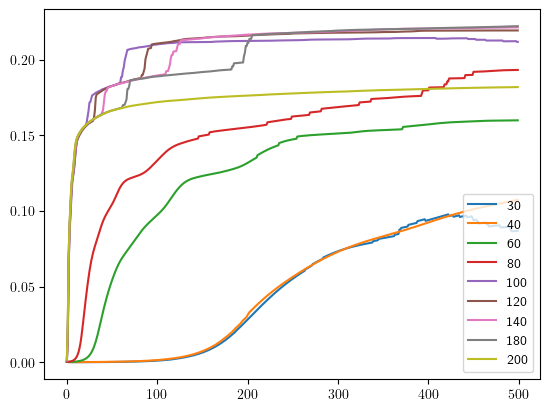

In [232]:
for key in std_dict.keys():
    color = 'r' if key <= 30 else 'b'
    plt.plot(std_dict[key], label = key,)
plt.legend()

In [222]:
std_dict[30]

[]

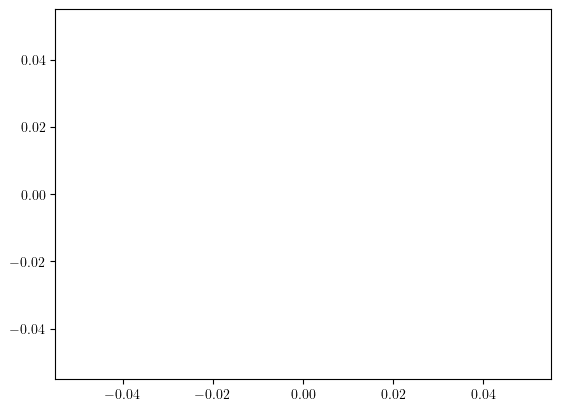

In [221]:
plt.plot(std_dict[30], label = key, color = color)

In [217]:
std_dict2 = {}
for numer in list_of_numbers:
    std_dict2[numer] = []

    for i in range(0, 20, 2):
        ah = []
        for j in idx_dict[numer]:
            try:
                # ah.append(np.std(all_dataset.get_trajectory(j, i)[0].numpy()))
                ah.append(np.max(all_dataset.get_trajectory(j, i)[0].numpy()) - np.min(all_dataset.get_trajectory(j, i)[0].numpy()))
            except:
                continue
        std_dict2[numer].append(np.mean(ah))
    
          




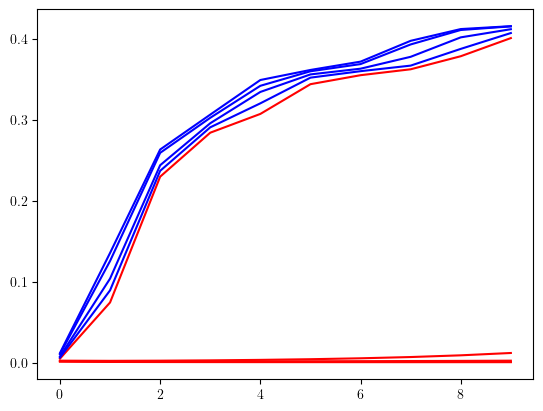

In [219]:
for key in std_dict2.keys():
    color = 'r' if key <= 100 else 'b'
    plt.plot(std_dict2[key], c = color)

In [ ]:
std_dict[30]

In [250]:
high_err = np.where(arr_of_numbers == 30)[0]
low_err = np.where(arr_of_numbers == 180)[0]

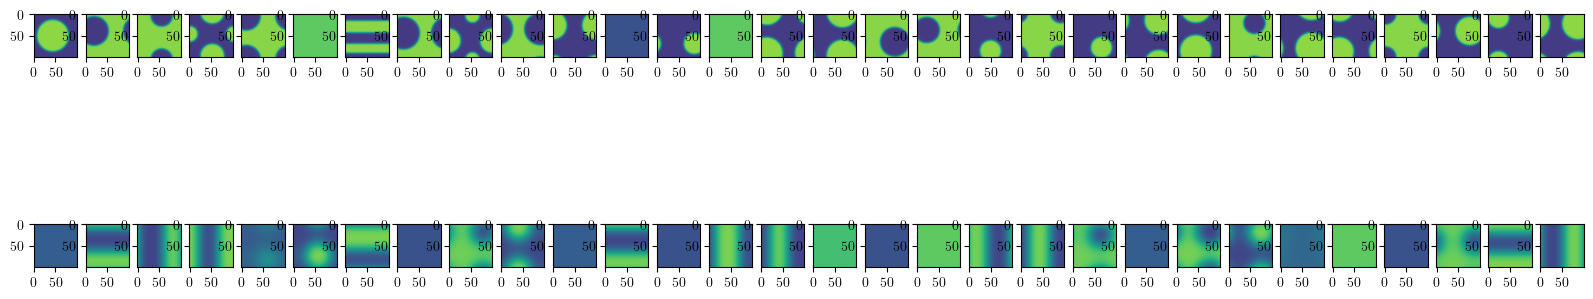

In [252]:
fig, ax = plt.subplots(2, 30, figsize=(20, 5))
for i in range(30):
    try:

        ax[0, i].imshow(all_dataset.get_trajectory(low_err[i], -2)[0], vmin = 0, vmax = 1)
        # ax[i].axis('off')
        ax[1, i].imshow(all_dataset.get_trajectory(high_err[i],-2)[0], vmin = 0, vmax = 1) 
    except:
        pass

In [233]:
std_dict = {}
for numer in list_of_numbers:
    std_dict[numer] = []

    for i in range(4, 20, 2):
        ah = []
        for j in idx_dict[numer]:
            try:
                ah.append(np.std(all_dataset.get_trajectory(j, -i)[0].numpy()))
                # ah.append(np.max(all_dataset.get_trajectory(j, i)[0].numpy()) - np.min(all_dataset.get_trajectory(j, i)[0].numpy()))
            except:
                continue
        std_dict[numer].append(np.mean(ah))
    
          




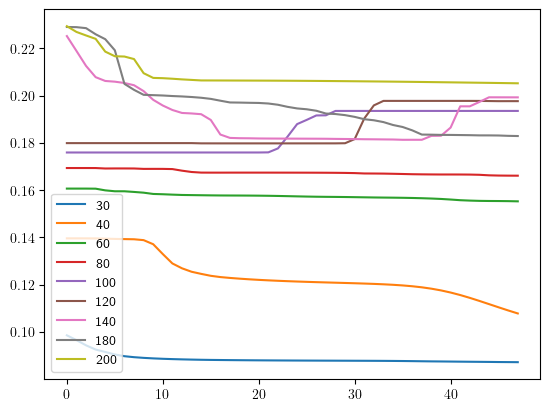

In [235]:
for key in std_dict.keys():
    
    plt.plot(std_dict[key], label = key)
plt.legend()

In [32]:
ood_dataset = H5pyDataset( oj(data_folder, "phase_field_ood.h5"), offset=2, start_offset=1, scale=1, num_channels=1, percentage = 1, )


In [33]:
len(ood_dataset.key_list)

110

In [31]:
print(len(train_dataset.key_list) + len(val_dataset.key_list) + len(test_dataset.key_list))

879


In [24]:
arr_of_numbers

['100',
 '100',
 '100',
 '30',
 '140',
 '40',
 '40',
 '40',
 '40',
 '40',
 '180',
 '180',
 '100',
 '80',
 '120',
 '30',
 '40',
 '180',
 '140',
 '180',
 '30',
 '80',
 '180',
 '30',
 '80',
 '80',
 '140',
 '140',
 '80',
 '200',
 '30',
 '120',
 '80',
 '140',
 '200',
 '40',
 '40',
 '200',
 '200',
 '30',
 '120',
 '100',
 '30',
 '140',
 '80',
 '80',
 '120',
 '140',
 '120',
 '40',
 '140',
 '180',
 '40',
 '120',
 '80',
 '120',
 '80',
 '140',
 '120',
 '40',
 '80',
 '140',
 '200',
 '120',
 '100',
 '180',
 '120',
 '200',
 '180',
 '200',
 '40',
 '80',
 '40',
 '40',
 '100',
 '180',
 '100',
 '140',
 '100',
 '200',
 '120',
 '140',
 '180',
 '200',
 '80',
 '80',
 '140',
 '80',
 '140',
 '140',
 '140',
 '100',
 '120',
 '180',
 '200',
 '180',
 '80',
 '40',
 '30',
 '140',
 '140',
 '30',
 '80',
 '30',
 '140',
 '100',
 '180',
 '120',
 '100',
 '40',
 '80',
 '180',
 '100',
 '80',
 '40',
 '100',
 '30',
 '180',
 '100',
 '180',
 '140',
 '30',
 '30',
 '100',
 '180',
 '40',
 '200',
 '140',
 '80',
 '80',
 '30',
 '80'

In [57]:
names = os.listdir(oj(data_folder, "Job_20220731_72_120nm", 'Job_20220731_72'))
for name in names:
    if name not in all_dataset.key_list:
        print(name)

Case_12540_228_120e-9_7


In [56]:
len(names)

79